In [2]:
import numpy
import itertools

#from BlackScholes import *
from random import Random
import scipy.stats as st
from numpy import *
from scipy import *
from time import *
from datetime import *
import numpy as np
import sys
import csv
import math

from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import scipy as sp
from scipy import stats  


import math
import torch
import gpytorch 
#pip install gpytorch

from time import *
from datetime import *




%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
def bsformula(cp, s, k, rf, t, v, div): 
        """ Price an option using the Black-Scholes model.
        cp: +1/-1 for call/put
        s: initial stock price
        k: strike price
        t: expiration time
        v: volatility
        rf: risk-free rate
        div: dividend
        """

        d1 = (np.log(s/k)+(rf-div+0.5*v*v)*t)/(v*np.sqrt(t))
        d2 = d1 - v*np.sqrt(t)

        optprice = (cp*s*np.exp(-div*t)*st.norm.cdf(cp*d1)) - (cp*k*np.exp(-rf*t)*st.norm.cdf(cp*d2))
        delta = cp*st.norm.cdf(cp*d1)
        vega  = s*np.sqrt(t)*st.norm.pdf(d1)
        return optprice, delta, vega

In [ ]:
""" Simulate dynamics under GBM """ 


def gbm(S0, mu, sigma, T = 1., N = 10, M= 1000):
    dt = T / N
    S = np.zeros((N+1, M))
    S[0,:] = S0
    
    for i in range(N):
        dW = np.random.normal(0, np.sqrt(dt), size=M)
        S[i+1,:] = S[i,:] + mu*S[i,:]*dt + sigma*S[i,:]*dW + 0.5*sigma**2*S[i,:]*(dW**2-dt)
    
    return S

In [6]:
nInt = 1024
r0 = 0.0002
S= 100
K = 100
#T = 0.01
r = r0
sigma = 0.1 #0.6
lmbda = 0.1
meanV = 0.1
v0 = 0.1
rho =-0.9
T = 2.0

In [ ]:

# Define the parameters of the Heston model
S0 = 100.0   # Initial stock price
K = 100   #Strike
V0 = 0.1    # Initial volatility
theta = 0.15 # Long-term mean of volatility
kappa = 0.1 # Speed of mean reversion
sigma = 0.1  # Volatility of volatility
rho = -0.9   # Correlation between stock price and volatility
T = 2.0      # Time horizon
r = 0.01     # Risk-free interest rate
M=1000  #Number of iterations
N=100 #Descritezation step
exercice = 'call' # Takes call or put

In [7]:
def heston_milstein_price(S0=100,K=100, v0=0.1, kappa=0.1, theta=0.15, sigma=0.1, rho=-0.9, r=0.01, M=1000,T=2,N = 100,exercice='call'):
    dt = T / N
    S = np.zeros((N+1, M))
    V = np.zeros((N+1, M))
    S[0,:] = S0
    V[0,:] = v0
    
    for i in range(1,N+1):
        # Generate random numbers
        # Use Cholesky decomposition to
        means = [0,0]
        stdevs = [1/3, 1/3]
        covs = [[stdevs[0]**2          , stdevs[0]*stdevs[1]*rho], 
                [stdevs[0]*stdevs[1]*rho,           stdevs[1]**2]]
        Z = np.random.multivariate_normal(means, 
                        covs, (M,)).T
        Z1 = Z[0,:]
        Z2 = Z[1,:]
            
        # Compute the drift and diffusion coefficients
        mu_S = r * S[i-1,:]
        mu_V = kappa * (theta - V[i-1,:])
        sigma_S = np.sqrt(V[i-1,:]) * S[i-1,:]
        sigma_V = sigma * np.sqrt(V[i-1,:])
        rho_SV = rho * sigma_S * sigma_V
        
        # Compute the increments
        dS = mu_S * dt + sigma_S * np.sqrt(dt) * Z1
        dV = mu_V * dt + sigma_V * np.sqrt(dt) * Z2
        dV += 0.25 * sigma**2 * (Z2**2 - 1) * dt
        
        # Update the stock price and volatility
        S[i,:] = S[i-1,:] + dS
        V[i,:] = V[i-1,:] + dV

    if exercice=='call':
       payoff = np.maximum(S[-1,:] - K, 0)
       Price= np.mean(np.exp(-r * T) * payoff)
    elif exercice=='put':
        payoff = np.maximum(K-S[-1,:], 0)
        Price= np.mean(np.exp(-r * T) * payoff)
    else:
      print('enter call or put')
        
    return Price


# GP model using  Milstein scheme for Heston price
 In the article, they used the Fourier Cosine method by Fang and
Oosterlee (2008) to generate the European Heston option price training and testing data for the GP.

In [9]:
training_number = 30 # change training size 
testing_number = 40   #use all data as test, otherwise shape not match


x1_train = np.array(np.linspace(0.01,1.0, training_number), dtype='float32').reshape(training_number, 1)
x2_train = np.array(np.linspace(0.01,1.0, training_number), dtype='float32').reshape(training_number, 1)


X1_train, X2_train = np.meshgrid(x1_train, x2_train)
x_train = np.zeros(len(X1_train.flatten())*2).reshape(len(X2_train.flatten()), 2)
x_train[:,0] = X1_train.flatten()
x_train[:,1] = X2_train.flatten()

In [10]:

#x1_test = torch.linspace(0, 1.0, testing_number)
#x2_test = torch.linspace(0.05, 1.0, testing_number) 
x1_test = np.array(np.linspace(0.1,0.9, testing_number), dtype='float32').reshape(testing_number, 1)
x2_test = np.array(np.linspace(0.05,1.0, testing_number), dtype='float32').reshape(testing_number, 1)

X1_test, X2_test = np.meshgrid(x1_test, x2_test)

x_test = np.zeros(len(X1_test.flatten())*2).reshape(len(X2_test.flatten()), 2)
x_test[:,0] = X1_test.flatten()
x_test[:,1] = X2_test.flatten()

In [12]:
nt = 11
timegrid = np.array(np.linspace(0.0,T,nt), dtype='float32').reshape(nt, 1)

# GP trainnig

In [13]:
def trainGPs(x_train, f, timegrid):

    gps = []
    i = 0
    for time in timegrid:
        print(time)
        
        y_train = []
        
        for idx in range(len(x_train)):
            #y_train.append(PyHeston.HestonCall(lb+interval*x_train[idx,0], x_train[idx,1], K, time, r, lmbda, meanV, sigma, rho, 0.4))
            y_train.append(f(x_train[idx,0], x_train[idx,1], time))
        y_train = np.array(y_train)
    
        
        sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 100.0))  #100000.0
        gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
        gp.fit(x_train,y_train)
        gps.append(gp)
        i += 1
    return gps   

In [14]:
def predictGPs(x_test, f, gps, timegrid):
    
    preds = []
    stds = []
    y_tests = []
    i = 0
    for time in timegrid:
        
        y_test_= []
        for idx in range(len(x_test)):
                
            #y_train.append(PyHeston.HestonCall(lb+interval*x_train[idx,0], x_train[idx,1], K, time, r, lmbda, meanV, sigma, rho, 0.4))
            y_test_.append(f(x_test[idx,0], x_test[idx,1], time))
            
        print(len(x_test), len(y_test_))
        y_test = np.array(y_test_)
        y_tests.append(y_test)
        
        # Find optimal model hyperparameters
        # Set into eval mode
        pred, std = gps[i].predict(x_test,return_std=True)
        preds.append(pred)
        stds.append(std)
        i+=1
    return y_tests, preds, stds 

In [17]:
lb = 1
ub = 400
portfolio = {}
portfolio['call']={}
portfolio['put']={}

portfolio['call']['price']= lambda x,y,z: heston_milstein_price(S0=lb+(ub-lb)*x,K=100, v0=y, kappa=0.1, theta=0.15, sigma=0.1, rho=-0.9, r=0.01,M=1000, T=z,N = 100,exercice='call')

portfolio['put']['price']= lambda x,y,z: heston_milstein_price(S0=lb+(ub-lb)*x,K=100, v0=y, kappa=0.1, theta=0.15, sigma=0.1, rho=-0.9, r=0.01,M=1000, T=z,N = 100,exercice='put')


In [18]:
for key in portfolio.keys():
  portfolio[key]['GPs'] = trainGPs(x_train, portfolio[key]['price'], timegrid)
  portfolio[key]['y_tests'], portfolio[key]['preds'], portfolio[key]['sigmas'] = predictGPs(x_test, portfolio[key]['price'], portfolio[key]['GPs'], timegrid)

[0.]
[0.2]
[0.4]
[0.6]
[0.8]
[1.]
[1.2]
[1.4]
[1.6]
[1.8]
[2.]
1600 1600
1600 1600
1600 1600
1600 1600
1600 1600
1600 1600
1600 1600
1600 1600
1600 1600
1600 1600
1600 1600
[0.]
[0.2]
[0.4]
[0.6]
[0.8]
[1.]


/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[1.2]
[1.4]
[1.6]
[1.8]
[2.]
1600 1600
1600 1600
1600 1600
1600 1600
1600 1600
1600 1600
1600 1600
1600 1600
1600 1600
1600 1600
1600 1600


# Plotting GP call price and the error


Time to maturity:[2.]


<Figure size 800x600 with 0 Axes>

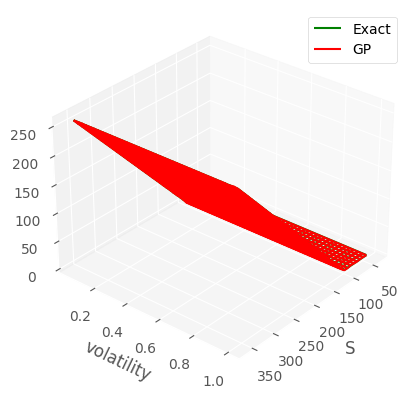

<Figure size 800x600 with 0 Axes>

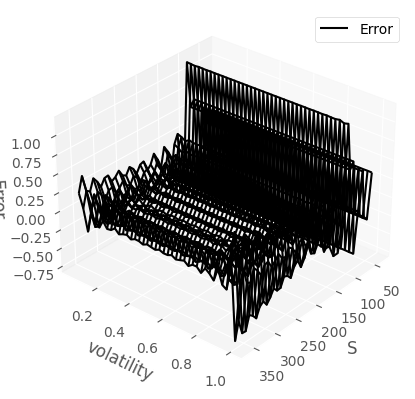

Time to maturity:[1.8]


<Figure size 800x600 with 0 Axes>

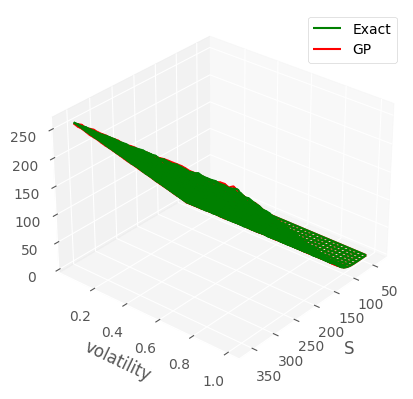

<Figure size 800x600 with 0 Axes>

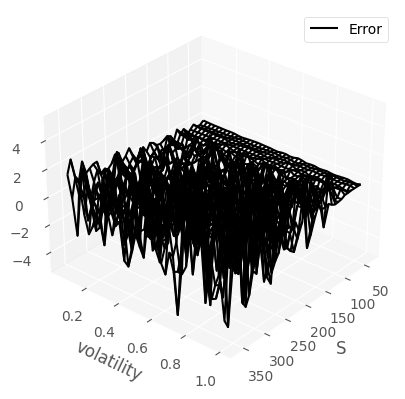

Time to maturity:[1.6]


<Figure size 800x600 with 0 Axes>

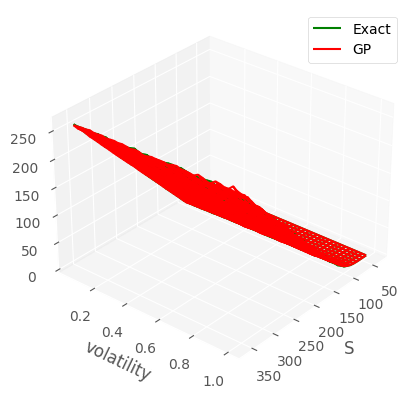

<Figure size 800x600 with 0 Axes>

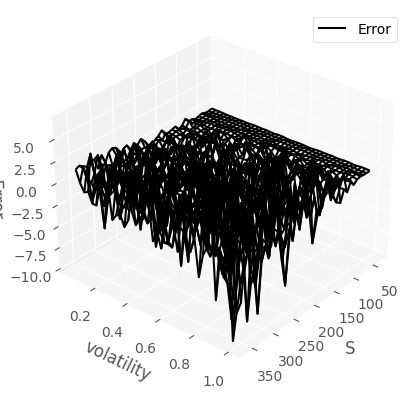

Time to maturity:[1.4]


<Figure size 800x600 with 0 Axes>

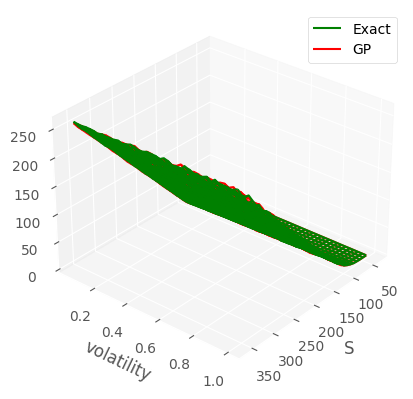

<Figure size 800x600 with 0 Axes>

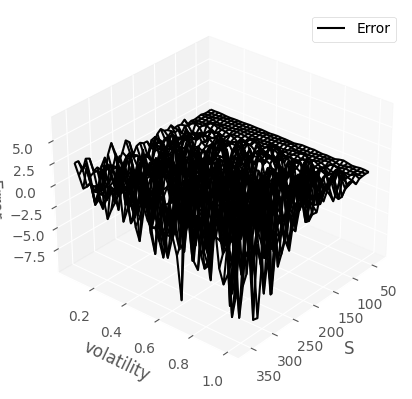

Time to maturity:[1.2]


<Figure size 800x600 with 0 Axes>

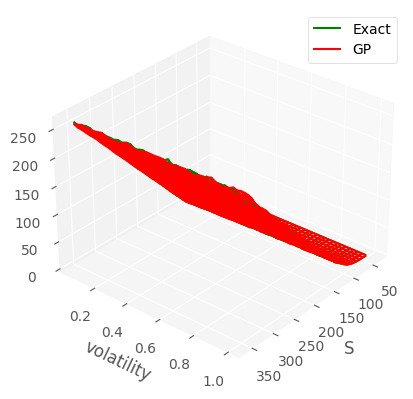

<Figure size 800x600 with 0 Axes>

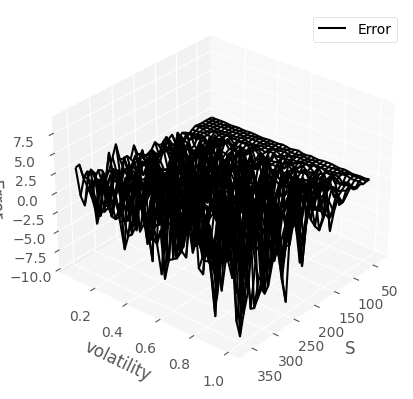

Time to maturity:[1.]


<Figure size 800x600 with 0 Axes>

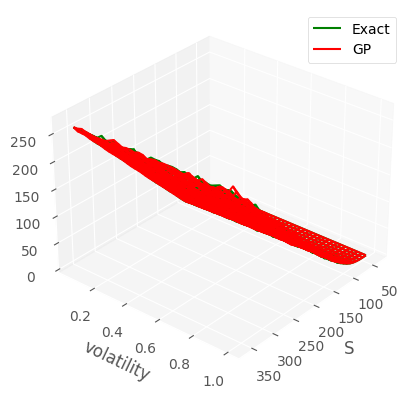

<Figure size 800x600 with 0 Axes>

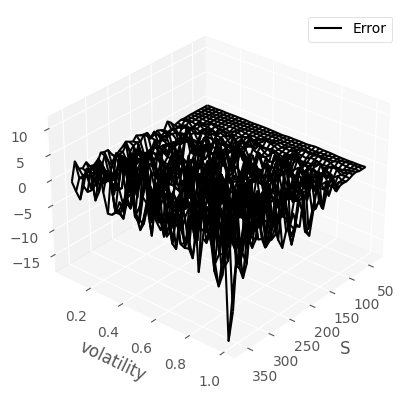

Time to maturity:[0.79999995]


<Figure size 800x600 with 0 Axes>

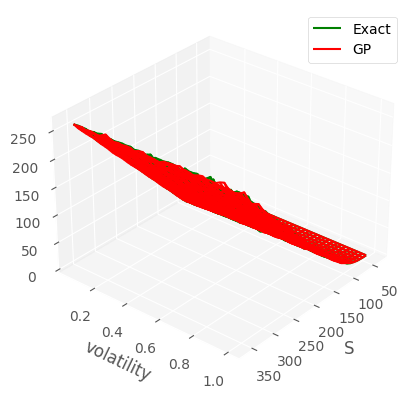

<Figure size 800x600 with 0 Axes>

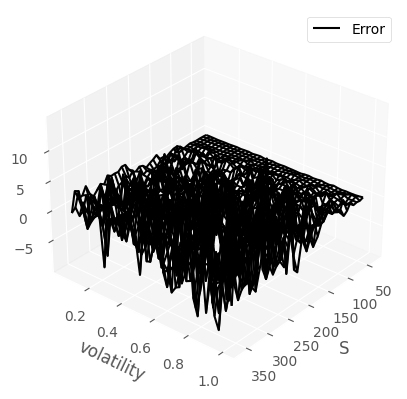

Time to maturity:[0.6]


<Figure size 800x600 with 0 Axes>

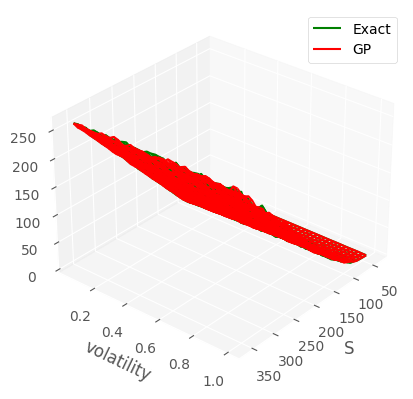

<Figure size 800x600 with 0 Axes>

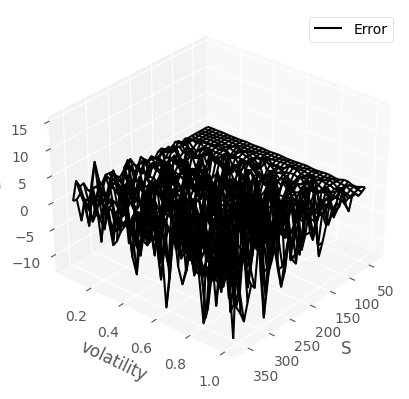

Time to maturity:[0.39999998]


<Figure size 800x600 with 0 Axes>

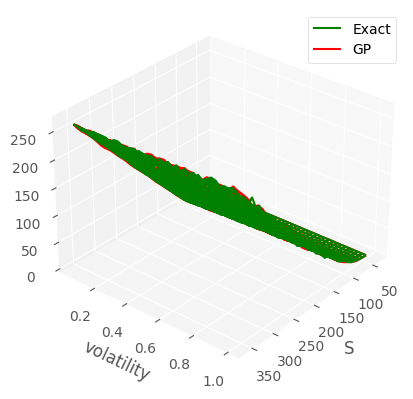

<Figure size 800x600 with 0 Axes>

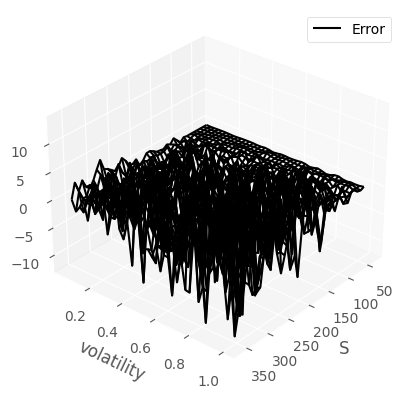

Time to maturity:[0.20000005]


<Figure size 800x600 with 0 Axes>

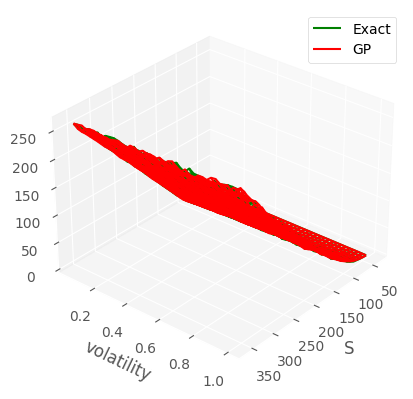

<Figure size 800x600 with 0 Axes>

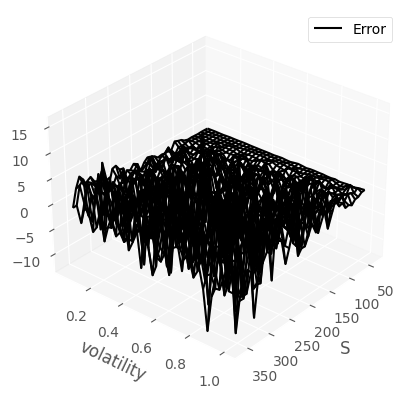

Time to maturity:[0.]


<Figure size 800x600 with 0 Axes>

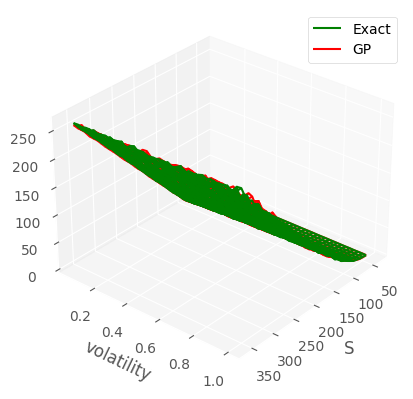

<Figure size 800x600 with 0 Axes>

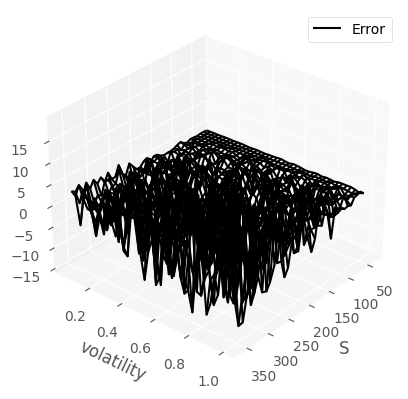

In [21]:
# plot the GP versus the testing data for each point on the timegrid

res = testing_number

x1_plot=lb+(ub-lb)*x_test[:,0].reshape(res,res)
x2_plot=x_test[:,1].reshape(res,res)

for t in range(len(timegrid)):
    print("Time to maturity:" + str(2.0-timegrid[t]))
    plt.figure(figsize = (8, 6), facecolor='white', edgecolor='black')
    plt.rcParams['axes.facecolor'] = 'white'
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    fig.savefig('plot_' + str(2.0-timegrid[t]) + '.png')
    
    
    ax.set_xlabel('S')
    ax.set_ylabel('volatility')
    ax.set_zlabel('V')
    ax.legend(loc = 'best', prop={'size':10})

    pred_plot  =  portfolio['call']['preds'][t].reshape(res,res) #portfolio['put']['preds'][t].reshape(res,res)
    test_plot = portfolio['call']['y_tests'][t].reshape(res,res) #portfolio['put']['y_tests'][t].reshape(res,res)

    
    angle = 40
    ax.view_init(30, angle)
    ax.plot_wireframe(x1_plot, x2_plot, test_plot, color='green', label = 'Exact')
    ax.plot_wireframe(x1_plot, x2_plot, pred_plot, color='red', label='GP' )
    ax.set_xlabel('S')
    ax.set_ylabel('volatility')
    ax.set_zlabel('V')
    ax.legend(loc = 'best', prop={'size':10})
    plt.show()
    
    plt.figure(figsize = (8, 6), facecolor='white', edgecolor='black')
    plt.rcParams['axes.facecolor'] = 'white'
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    
    angle = 40
    ax.view_init(30, angle)
    ax.plot_wireframe(x1_plot, x2_plot, test_plot-pred_plot, color='black', label = 'Error')
    ax.set_xlabel('S')
    ax.set_ylabel('volatility')
    ax.set_zlabel('Error')
    ax.legend(loc = 'best', prop={'size':10})
    fig.savefig('plot_error_' + str(2.0-timegrid[t]) + '.png')
    plt.show()
    
    

**Comment**:
The best graph belongs to time to maturity equals to 2. We think this is due to our pricing method which is descritezation method which can make some  descritezation errors.

# GP performance comparing to BS model




In [ ]:
bsformula(1, lb+(ub-lb)*x, KC, r, T, sigma, 0)[0]

In [ ]:
r = 0.0002  # risk-free rate
S= 100      # Underlying spot
KC = 130    # Call strike
KP = 70     # Put strike
sigma = 0.4 # implied volatility
T = 2.0     # Time to maturity

In [ ]:
# define the call and put prices using the BS model
call = lambda x: bsformula(1, lb+(ub-lb)*x, KC, r, T, sigma, 0)[0]
put = lambda x: bsformula(-1, lb+(ub-lb)*x, KP, r, T, sigma, 0)[0]

In [ ]:
lb = 0.001           # lower bound on domain
ub = 300             # upper bound on domain
training_number = 5  # Number of training samples
testing_number = 100 # Number of testing samples

train_x_1 = np.array(np.linspace(0,1, training_number), dtype='float32').reshape(training_number, 1)
train_y_1 = []
for S in train_x_1:
    train_y_1.append(call(S))
    
test_x_1 = np.array(np.linspace(0,1, testing_number), dtype='float32').reshape(testing_number, 1)
test_y_1 = []
for S in test_x_1:
    test_y_1.append(call(S))

In [ ]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-05, 1000.0))  #100000.0
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(train_x_1,train_y_1)

/Users/matthewdixon/scratch/DL/MarketVectors/venv_tf_old/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.07397295]), 'nit': 3, 'funcalls': 47}
  " state: %s" % convergence_dict)


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1), n_restarts_optimizer=20,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [ ]:
y_pred_1, sigma_1 = gp.predict(test_x_1, return_std=True)

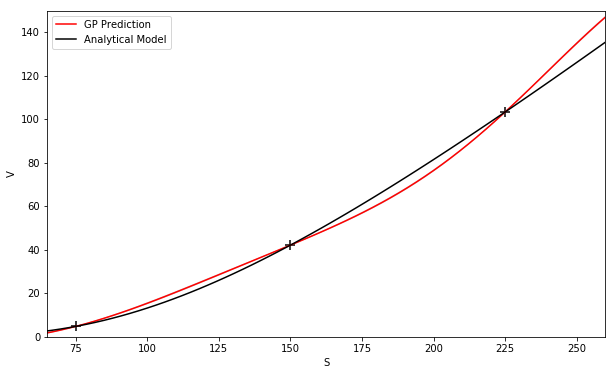

In [ ]:
# predictionn plot with var band 
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*test_x_1.flatten(), y_pred_1, color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*test_x_1.flatten(), test_y_1, color = 'black', label = 'BS model')
plt.scatter(lb+(ub-lb)*train_x_1, train_y_1, color = 'black', marker = '+', s = 100) 
plt.fill_between(lb+(ub-lb)*test_x_1.flatten(), (y_pred_1.T-2*sigma_1).flatten(), (y_pred_1.T+2*sigma_1).flatten(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([KC/2.0,2.0*KC])
plt.ylim([0,150])
plt.xlabel('S')
plt.ylabel('V')

# GP Put pricer

In [ ]:
train_x_2 = np.array(np.linspace(0,1, training_number), dtype='float32').reshape(training_number, 1)
train_y_2 = []
for S in train_x_2:
    train_y_2.append(put(S))
    
testing_number = 100
test_x_2 = np.array(np.linspace(0,1, testing_number), dtype='float32').reshape(testing_number, 1)
test_y_2 = []
for S in test_x_2:
    test_y_2.append(put(S))

In [ ]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-05, 1000.0)) 
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(train_x_2,train_y_2)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1), n_restarts_optimizer=20,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [ ]:
y_pred_2, sigma_2 = gp.predict(test_x_2, return_std=True)

(0, 40)

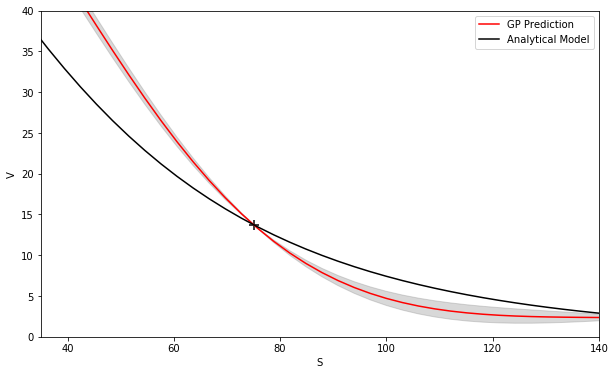

In [ ]:
# prediction plot with var band 
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*test_x_2.flatten(), y_pred_2, color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*test_x_2.flatten(), test_y_2, color = 'black', label = 'BS Model')
plt.scatter(lb+(ub-lb)*train_x_2.flatten(), train_y_2, color = 'black', marker = '+', s = 100) 
plt.fill_between(lb+(ub-lb)*test_x_2.flatten(), (y_pred_2.T-2*sigma_2).flatten(), (y_pred_2.T+2*sigma_2).flatten(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlabel('S')
plt.ylabel('V')
plt.xlim([KP/2.0,2.0*KP])
plt.ylim([0,40])

# portfolio value

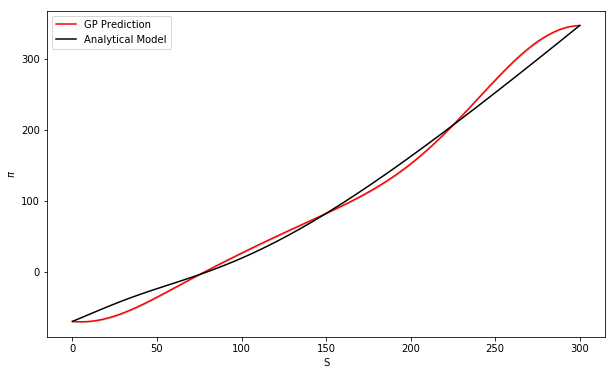

In [ ]:
# portfolio prediction plot with var band 
y_pred = 2.0*y_pred_1 - y_pred_2 # long 2 calls and short a put
test_y = 2.0*np.array(test_y_1) - np.array(test_y_2)
sigma = np.sqrt(sigma_1*sigma_1 + sigma_2*sigma_2)
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*test_x_2.flatten(), y_pred, color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*test_x_2.flatten(), test_y.flatten(), color = 'black', label = 'BS Model')
plt.fill_between(lb+(ub-lb)*test_x_2.flatten(), (y_pred.T-2*sigma).flatten(), (y_pred.T+2*sigma).flatten(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlabel('S')
plt.ylabel('$\pi$')

# Derivativies computations

In [ ]:
lb = 0
ub = 300
training_number = 100
testing_number = 50
sigma_n = 1e-8 # additive noise in GP

call = lambda x,y: bsformula(1, lb+(ub-lb)*x, KC, r, T, y, 0)[0]
put = lambda x,y: bsformula(-1, lb+(ub-lb)*x, KP, r, T, y, 0)[0]

In [ ]:
x_train = np.array(np.linspace(0.01,1.2, training_number), dtype='float32').reshape(training_number, 1)
x_test = np.array(np.linspace(0.01,1.0, testing_number), dtype='float32').reshape(testing_number, 1)

y_train = []
    
for idx in range(len(x_train)):
    y_train.append(call(x_train[idx], sigma))
y_train = np.array(y_train)

# delta

In [ ]:
x_train = np.array(np.linspace(0.01,1.2, training_number), dtype='float32').reshape(training_number, 1)
x_test = np.array(np.linspace(0.01,1.0, testing_number), dtype='float32').reshape(testing_number, 1)

y_train = []
    
for idx in range(len(x_train)):
    y_train.append(call(x_train[idx], sigma))
y_train = np.array(y_train)

sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 10000.0)) #+ WhiteKernel(noise_level = 1e-12) #100000.0
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(x_train,y_train)
y_pred, sigma_hat = gp.predict(x_test, return_std=True)
    
l = gp.kernel_.length_scale
rbf= gaussian_process.kernels.RBF(length_scale=l)
 
Kernel= rbf(x_train, x_train)
K_y = Kernel + np.eye(training_number) * sigma_n
L = sp.linalg.cho_factor(K_y)
alpha_p = sp.linalg.cho_solve(np.transpose(L), y_train)
    
k_s = rbf(x_test, x_train)
k_s_prime = (x_train.T - x_test) * k_s / l**2
f_prime = np.dot(k_s_prime, alpha_p)/(ub-lb)

/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [ ]:
delta = lambda x,y:  bsformula(1, lb+(ub-lb)*x, KC, r, T, y, 0)[0]
delta(x_test, sigma) - f_prime

array([[ 4.23754737e-04],
       [-1.77155336e-04],
       [ 9.66151288e-05],
       [ 3.54402659e-03],
       [ 2.19400131e-02],
       [ 8.04980504e-02],
       [ 2.15420009e-01],
       [ 4.68528018e-01],
       [ 8.81328498e-01],
       [ 1.49109107e+00],
       [ 2.32825207e+00],
       [ 3.41556145e+00],
       [ 4.76778012e+00],
       [ 6.39316761e+00],
       [ 8.29372050e+00],
       [ 1.04667740e+01],
       [ 1.29059023e+01],
       [ 1.56018900e+01],
       [ 1.85435225e+01],
       [ 2.17182829e+01],
       [ 2.51128994e+01],
       [ 2.87138003e+01],
       [ 3.25074214e+01],
       [ 3.64804141e+01],
       [ 4.06198766e+01],
       [ 4.49134151e+01],
       [ 4.93492845e+01],
       [ 5.39164270e+01],
       [ 5.86044605e+01],
       [ 6.34036909e+01],
       [ 6.83051151e+01],
       [ 7.33003801e+01],
       [ 7.83817328e+01],
       [ 8.35420716e+01],
       [ 8.87748616e+01],
       [ 9.40741276e+01],
       [ 9.94342875e+01],
       [ 1.04850276e+02],
       [ 1.1

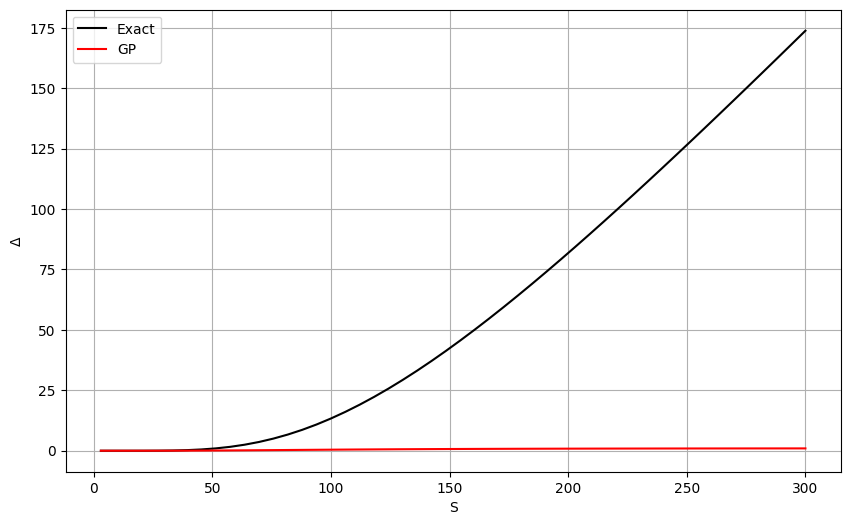

In [ ]:
plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*x_test, delta(x_test,sigma), color = 'black', label = 'Exact')
plt.plot(lb+(ub-lb)*x_test, f_prime, color = 'red', label = 'GP')
plt.grid(True)
plt.xlabel('S')
plt.ylabel('$\Delta$')
plt.legend(loc = 'best', prop={'size':10})

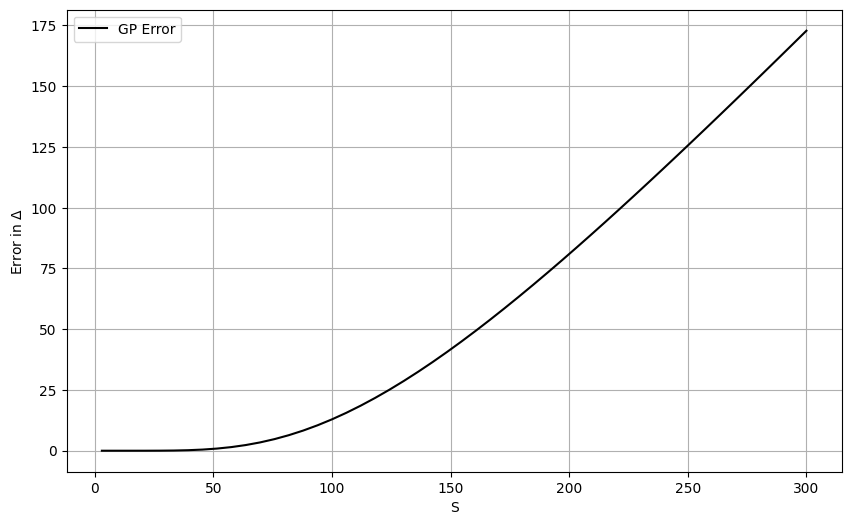

In [ ]:
plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*x_test, delta(x_test,sigma) - f_prime, color = 'black', label = 'GP Error')
plt.grid(True)
plt.xlabel('S')
plt.ylabel('Error in $\Delta$')
plt.legend(loc = 'best', prop={'size':10})

## vega

In [ ]:
x_train = np.array(np.linspace(0.01,1.2, training_number), dtype='float32').reshape(training_number, 1)
x_test = np.array(np.linspace(0.01,1.0, testing_number), dtype='float32').reshape(testing_number, 1)

y_train = []
    
for idx in range(len(x_train)):
    y_train.append(call((S0-lb)/(ub-lb), x_train[idx]))
y_train = np.array(y_train)

sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 10000.0)) #+ WhiteKernel(noise_level = 1e-12) #100000.0
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(x_train,y_train)
y_pred, sigma_hat = gp.predict(x_test, return_std=True)
    
l = gp.kernel_.length_scale
rbf= gaussian_process.kernels.RBF(length_scale=l)
 
Kernel= rbf(x_train, x_train)
K_y = Kernel + np.eye(training_number) * sigma_n
L = sp.linalg.cho_factor(K_y)
alpha_p = sp.linalg.cho_solve(np.transpose(L), y_train)
    
k_s = rbf(x_test, x_train)

k_s_prime = np.zeros([len(x_test), len(x_train)])
for i in range(len(x_test)):
    for j in range(len(x_train)):
        k_s_prime[i,j]=(1.0/l**2)*(x_train[j]-x_test[i])*k_s[i,j]
        
f_prime = np.dot(k_s_prime, alpha_p)

/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [ ]:
vega = lambda x,y: bsformula(1, lb+(ub-lb)*x, KC, r, T, y, 0)[2]
vega((S0-lb)/(ub-lb), x_test) - f_prime

array([[-0.0379362 ],
       [ 0.00727618],
       [ 0.0849228 ],
       [ 0.02146378],
       [ 0.09285664],
       [-0.00781419],
       [ 0.03001456],
       [ 0.0219843 ],
       [-0.02550651],
       [ 0.03181571],
       [ 0.03085656],
       [ 0.01229814],
       [ 0.03017001],
       [ 0.01018191],
       [ 0.00121988],
       [ 0.01014983],
       [ 0.01377621],
       [ 0.00277257],
       [ 0.01042852],
       [ 0.0157123 ],
       [ 0.0090762 ],
       [ 0.01125682],
       [ 0.01254304],
       [ 0.00630115],
       [ 0.00206147],
       [ 0.00386585],
       [ 0.00014294],
       [-0.00173475],
       [-0.00142232],
       [-0.00207746],
       [-0.00044149],
       [ 0.00125461],
       [-0.00050712],
       [ 0.00041891],
       [ 0.00265396],
       [ 0.0042374 ],
       [ 0.00238734],
       [ 0.00391802],
       [ 0.00318074],
       [-0.00084481],
       [ 0.00131337],
       [-0.00106006],
       [-0.00415478],
       [-0.00184806],
       [-0.024526  ],
       [-0

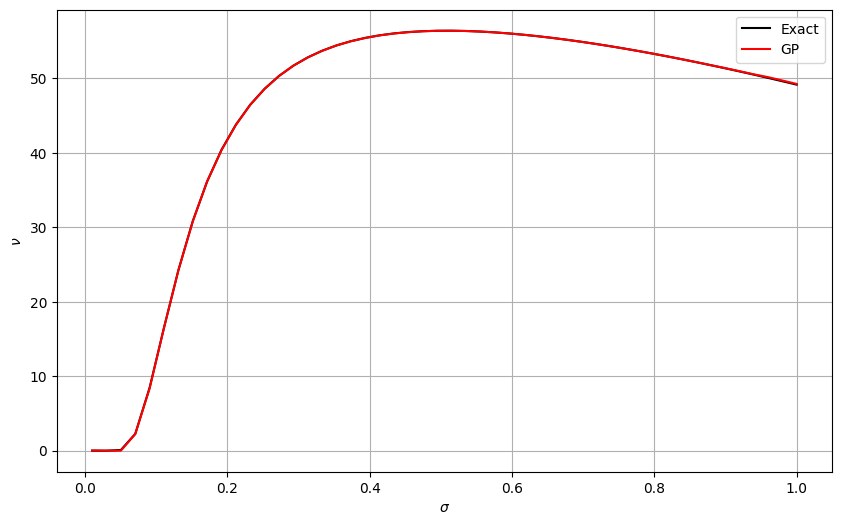

In [ ]:
plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(x_test, vega((S0-lb)/(ub-lb), x_test), color = 'black', label = 'Exact')
plt.plot(x_test, f_prime, color = 'red', label = 'GP')
plt.grid(True)
plt.xlabel('$\\sigma$')
plt.ylabel('$\\nu$')
plt.legend(loc = 'best', prop={'size':10})

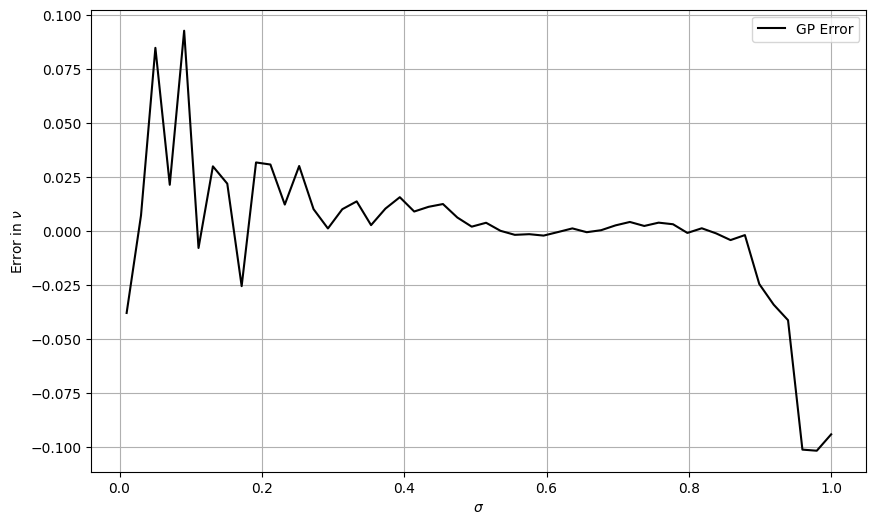

In [ ]:
plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(x_test, vega((S0-lb)/(ub-lb), x_test)-f_prime, color = 'black', label = 'GP Error')
plt.grid(True)
plt.xlabel('$\\sigma$')
plt.ylabel('Error in $\\nu$')
plt.legend(loc = 'best', prop={'size':10})

# MC-GP estimation of the EPE 


In [ ]:
def trainGPs(x_train, f, timegrid):

    gps = []
    i = 0
    for time in timegrid:
        
        y_train = []
        
        for idx in range(len(x_train)):
             y_train.append(f(x_train[idx], time))
        y_train = np.array(y_train)

        sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 100.0))  #100000.0
        gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
        gp.fit(x_train,y_train)
        gps.append(gp)
        i += 1
    return gps   

In [ ]:
def predictGPs(x_test, f, gps, timegrid):
    
    preds = []
    stds = []
    y_tests = []
    i = 0
    for time in timegrid:
        
        y_test_= []
        for idx in range(len(x_test)):
            y_test_.append(f(x_test[idx], time))
            
        y_test = np.array(y_test_)
        y_tests.append(y_test)
        
        # Find optimal model hyperparameters
        # Set into eval mode
        pred, std = gps[i].predict(x_test,return_std=True)
        preds.append(pred)
        stds.append(std)
        i+=1
    return y_tests, preds, stds 

In [ ]:
# specify the portfolio
KC = 110    # Call strike
KP = 90     # Put strike
lb = 0.01
ub = 400
r  = 0
sigma = 0.3
nt = 11
T = 2.0
S0 = 100
timegrid = np.array(np.linspace(0.0,T,nt), dtype='float32').reshape(nt, 1)


portfolio = {}
portfolio['call']={}
portfolio['put']={}

portfolio['call']['price']= lambda x,y: bsformula(1, lb+(ub-lb)*x, KC, r, y, sigma, 0)[0]
portfolio['put']['price']= lambda x,y: bsformula(-1, lb+(ub-lb)*x, KP, r, y, sigma, 0)[0]
portfolio['call']['weight']=2.0
portfolio['put']['weight']=-1.0

In [ ]:
# prepare training and test data
training_number= 100
testing_number = 50
x_train = np.array(np.linspace(0.0,1.0, training_number), dtype='float32').reshape(training_number, 1)
x_test = np.array(np.linspace(0.0,1.0, testing_number), dtype='float32').reshape(testing_number, 1)

In [ ]:
# train and predict over portfolio
for key in portfolio.keys():
    portfolio[key]['GPs'] = trainGPs(x_train, portfolio[key]['price'], timegrid)
    portfolio[key]['y_tests'], portfolio[key]['preds'], portfolio[key]['sigmas'] = predictGPs(x_test, portfolio[key]['price'], portfolio[key]['GPs'], timegrid)

/content/BlackScholes.py:16: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(s/k)+(rf-div+0.5*v*v)*t)/(v*np.sqrt(t))
/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LN

In [ ]:
def CVA_simulation(sim_params, model_params, def_model):
    
    n_sim_dt = sim_params['n_sim_dt'] # number of Euler stpes
    M        = sim_params['M']        # number of paths
    nt       = sim_params['nt']       # number of exposure dates
    timegrid = sim_params['timegrid'] # time grid of exposure dates
    
    r        = model_params['r']
    sigma    = model_params['sigma']
    T        = model_params['T'] 
    t0       = model_params['t0'] 
    S0       = model_params['S0'] 
    
    gamma_0  = def_model['gamma_0']
    gamma_1  = def_model['gamma_1']
    
    
    stride = n_sim_dt/(nt-1)
    idx = np.arange(0,n_sim_dt+1,stride, dtype=int)
    
    pi = {}
    pi['tilde'] = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M)     # GP portfolio value
    pi['exact'] = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M)     # BS portfolio value
    pi['tilde_var'] = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M) # GP portfolio variance
    gamma = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M)           # hazard rates
    dPD = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M)             # default probabilities
    
    #simulate underlying GBM dynamics using Euler
    S = gbm(S0, r, sigma, T-t0, n_sim_dt, M)
    
    if (def_model['calibrate']):
        x  = np.exp(S0/S)**gamma_1
        # default probability (assumed to be estimated from credit spread)
        dt = timegrid[1]-timegrid[0] 
        f  = lambda y: np.abs(np.mean(np.prod(x**(-y*dt), axis=0)) - def_model['p']) 
        res = sp.optimize.basinhopping(f, 0.1, niter=10)
        i = 1   
        while (abs(res.fun) >1e-3):   
          res = sp.optimize.basinhopping(f, 0.1, niter=100*i)
          i *= 2
        gamma_0= res.x[0]
        print("calibration:", gamma_0, gamma_1, f(gamma_0), res.fun)  
    
    
    for m in range(M):  
      i = 1 
      exp_factor=1
        
      for time in timegrid[1:]:
        dt = timegrid[i]-timegrid[i-1] 
        
        S_= S[idx[i],m] # simulated S
        # avoid simulated S breaching boundaries of domain
        if (S_<lb):
            mins=S_
            S_=lb
        if (S_>ub):
            S_=ub
            maxs=S_
    
        pred_= 0
        v_ = 0
        var_ =0 
    
        for key in portfolio.keys():
           pred, std = portfolio[key]['GPs'][i].predict(np.array([(S_-lb)/(ub-lb)]).reshape(1,-1),return_std=True) 
           pred_ += portfolio[key]['weight']*pred
           var_ += (portfolio[key]['weight']*std)**2 
       
           if key=='call':
              v_ += portfolio[key]['weight']*bsformula(1, S_, KC, r, time, sigma, 0)[0]
           else:
              v_ += portfolio[key]['weight']*bsformula(-1, S_, KP, r, time, sigma, 0)[0]
        pi['tilde'][i-1,m] = np.maximum(pred_,0)
        pi['exact'][i-1,m] = np.maximum(v_,0)
        pi['tilde_var'][i-1,m] =var_ 
          
        # default intensity model
        gamma[i-1,m] = gamma_0*(S0/S_)**gamma_1    
        
        # compute default probabilities  
        exp_factor*=np.exp(-dt*gamma[i-1,m])    
        dPD[i-1,m]= gamma[i-1,m]*exp_factor
        
        i += 1
    # compute CVA
    i = 0
    CVA ={}
    CVA['tilde'] = 0
    CVA['exact'] = 0
    CVA['tilde_up'] = 0
    CVA['tilde_down'] = 0
   
    for time in timegrid[1:]:
        dt = timegrid[i+1]-timegrid[i]
        mu_tilde = np.mean(dPD[i,:]*pi['tilde'][i,:])*np.exp(-r*(time-t0))*dt
        CVA['tilde'] += mu_tilde
        std_err_MC = np.std(dPD[i,:]*pi['tilde'][i,:])*np.exp(-r*(time-t0))*dt/np.sqrt(M)
        CVA['tilde_up'] += mu_tilde + 2.0*std_err_MC
        CVA['tilde_down'] += mu_tilde - 2.0*std_err_MC
        CVA['exact'] += np.mean(dPD[i,:]*pi['exact'][i,:])*np.exp(-r*(time-t0))*dt
        i+=1
    CVA['tilde'] *= (1-def_model['recovery'])
    CVA['tilde_up'] *= (1-def_model['recovery'])
    CVA['tilde_down'] *= (1-def_model['recovery'])
    CVA['exact'] *= (1-def_model['recovery'])
        
    return(CVA, pi)

# CVA

In [ ]:
sim_params = {}
model_params = {}
def_model = {}
  
model_params['r'] = r        # risk-free rate
model_params['sigma'] = sigma  # implied volatility
model_params['T'] = T        # Time to maturity 
model_params['t0'] = 0
model_params['S0'] = S0     # Underlying spot
     
# parameters to the default intensity model    
def_model['gamma_0'] = 0.01
def_model['gamma_1'] = 1.2
def_model['calibrate'] = False    
def_model['recovery'] = 0.4

sim_params['n_sim_dt'] = 100 # number of Euler stpes
sim_params['M']  = 1000      # number of paths
sim_params['nt'] = nt        # number of exposure dates

sim_params['timegrid']= timegrid # time grid of exposure dates

In [ ]:
# train and predict over portfolio
for key in portfolio.keys():
    portfolio[key]['GPs'] = trainGPs(x_train, portfolio[key]['price'], timegrid)
    portfolio[key]['y_tests'], portfolio[key]['preds'], portfolio[key]['sigmas'] = predictGPs(x_test, portfolio[key]['price'], portfolio[key]['GPs'], timegrid)

CVA_0, pi = CVA_simulation(sim_params, model_params, def_model)

/content/BlackScholes.py:16: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(s/k)+(rf-div+0.5*v*v)*t)/(v*np.sqrt(t))
/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LN

In [ ]:
CVA_0

{'tilde': array([0.17088747], dtype=float32),
 'exact': array([0.17088753], dtype=float32),
 'tilde_up': array([0.18514042], dtype=float32),
 'tilde_down': array([0.15663457], dtype=float32)}

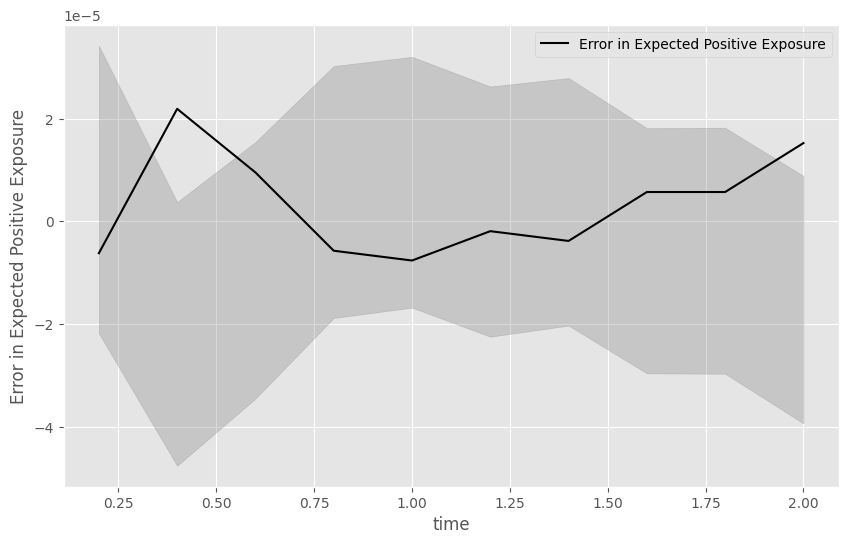

In [ ]:
# Error plot
up = np.mean(pi['tilde'], axis=1) -np.mean(pi['exact'], axis=1)+2.0*np.sqrt(np.mean(pi['tilde_var'], axis=1))   # 95% confident interval 
down = np.mean(pi['tilde'], axis=1) -np.mean(pi['exact'], axis=1)- 2.0*np.sqrt(np.mean(pi['tilde_var'], axis=1))   # 95% confident interval 

plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(timegrid[1:], np.mean(pi['exact'], axis=1)-np.mean(pi['tilde'], axis=1), color = 'black', label = 'Error in Expected Positive Exposure')
plt.fill_between(timegrid[1:].flatten(), np.array(down), np.array(up), color = 'grey', alpha=0.3)
plt.grid(True)
#plt.xlim(90, 110)
plt.xlabel('time')
plt.ylabel('Error in Expected Positive Exposure')
plt.legend(loc = 'best', prop={'size':10})

# CVA VaR and Uncertainty Quantification

In [ ]:
def trainGPs(x_train, f, timegrid):

    gps = []
    i = 0
    for time in timegrid:
        
        y_train = []
        
        for idx in range(len(x_train)):
             y_train.append(f(x_train[idx], time))
        y_train = np.array(y_train)
    
        
        sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 100.0))  #100000.0
        gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
        gp.fit(x_train,y_train)
        gps.append(gp)
        i += 1
    return gps   

In [ ]:
def predictGPs(x_test, f, gps, timegrid):
    
    preds = []
    stds = []
    y_tests = []
    i = 0
    for time in timegrid:
        
        y_test_= []
        for idx in range(len(x_test)):
            y_test_.append(f(x_test[idx], time))
            
        y_test = np.array(y_test_)
        y_tests.append(y_test)
        
        # Find optimal model hyperparameters
        # Set into eval mode
        pred, std = gps[i].predict(x_test,return_std=True)
        preds.append(pred)
        stds.append(std)
        i+=1
    return y_tests, preds, stds 

In [ ]:
# specify the portfolio
KC = 110    # Call strike
KP = 90     # Put strike
lb = 0.01
ub = 400
r  = 0
T  = 2
sigma = 0.3
nt = 11
S0 = 100
n_sim_dt = 100

In [ ]:
# specify the portfolio
portfolio = {}
portfolio['call']={}
portfolio['put']={}

portfolio['call']['price']= lambda x,y: bsformula(1, lb+(ub-lb)*x, KC, r, y, sigma, 0)[0]
portfolio['put']['price']= lambda x,y: bsformula(-1, lb+(ub-lb)*x, KP, r, y, sigma, 0)[0]
portfolio['call']['weight']=2.0
portfolio['put']['weight']=-1.0

In [ ]:
# prepare training and test data
training_number= 100
testing_number = 50
x_train = np.array(np.linspace(0.0,1.0, training_number), dtype='float32').reshape(training_number, 1)
x_test = np.array(np.linspace(0.0,1.0, testing_number), dtype='float32').reshape(testing_number, 1)

In [ ]:
sim_params = {}
model_params = {}
def_model = {}
  
model_params['r'] = r        # risk-free rate
model_params['sigma'] = sigma  # implied volatility
model_params['T'] = T        # Time to maturity 
model_params['t0'] = 0
model_params['S0'] = S0     # Underlying spot
     
# parameters of the default intensity model    
def_model['gamma_0'] = 0.01
def_model['gamma_1'] = 1.2
def_model['calibrate'] = False    # calibrate the prior \gamma_0 to spreads
def_model['recovery'] = 0.4
def_model['p'] = 0.05

sim_params['n_sim_dt'] = n_sim_dt # number of Euler stpes
sim_params['M']  = 100      # number of paths
sim_params['nt'] = nt        # number of exposure dates

timegrid = np.array(np.linspace(0.0,T,nt), dtype='float32').reshape(nt, 1)

sim_params['timegrid']= timegrid # time grid of exposure dates

In [ ]:
# train and predict over portfolio
for key in portfolio.keys():
    portfolio[key]['GPs'] = trainGPs(x_train, portfolio[key]['price'], timegrid)
    portfolio[key]['y_tests'], portfolio[key]['preds'], portfolio[key]['sigmas'] = predictGPs(x_test, portfolio[key]['price'], portfolio[key]['GPs'], timegrid)

/content/BlackScholes.py:16: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(s/k)+(rf-div+0.5*v*v)*t)/(v*np.sqrt(t))
/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LN

In [ ]:
def CVA_simulation(sim_params, model_params, def_model, recalibrate=False):
    
    n_sim_dt = sim_params['n_sim_dt'] # number of Euler stpes
    M        = sim_params['M']        # number of paths
    nt       = sim_params['nt']       # number of exposure dates
    timegrid = sim_params['timegrid'] # time grid of exposure dates
    
    r        = model_params['r']
    sigma    = model_params['sigma']
    T        = model_params['T'] 
    t0       = model_params['t0'] 
    S0       = model_params['S0'] 
    
    gamma_0  = def_model['gamma_0']
    gamma_1  = def_model['gamma_1']
    
    
    stride = n_sim_dt/(nt-1)
    idx = np.arange(0,n_sim_dt+1,stride, dtype=int)
    
    pi = {}
    pi['tilde'] = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M)     # GP portfolio value
    pi['exact'] = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M)     # BS portfolio value
    pi['tilde_var'] = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M) # GP portfolio variance
    gamma = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M)           # hazard rates
    dPD = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M)             # default probabilities
    
    #simulate underlying GBM dynamics using Euler
    S = gbm(S0, r, sigma, T-t0, n_sim_dt, M)
    
    if (recalibrate):
        x  = np.exp(S0/S)**gamma_1  #modification
        # default probability (assumed to be estimated from credit spread)
        dt = timegrid[1]-timegrid[0] 
        f  = lambda y: np.abs(np.mean(np.prod(x**(-y*dt), axis=0)) - def_model['p']) 
        res = sp.optimize.basinhopping(f, 0.1, niter=10)
        i = 1   
        while (abs(res.fun) >1e-3):   
          res = sp.optimize.basinhopping(f, 0.1, niter=100*i)
          i *= 2
        gamma_0= res.x[0]
        print("calibration:", gamma_0, gamma_1, f(gamma_0), res.fun)  
    
    
    for m in range(M):  
      i = 1 
      exp_factor=1
        
      for time in timegrid[1:]:
        dt = timegrid[i]-timegrid[i-1] 
        
        S_= S[idx[i],m] # simulated S
        # avoid simulated S breaching boundaries of domain
        if (S_<lb):
            mins=S_
            S_=lb
        if (S_>ub):
            S_=ub
            maxs=S_
    
        pred_= 0
        v_ = 0
        var_ =0 
    
        for key in portfolio.keys():
           pred, std = portfolio[key]['GPs'][i].predict(np.array([(S_-lb)/(ub-lb)]).reshape(1,-1),return_std=True) 
           pred_ += portfolio[key]['weight']*pred
           var_ += (portfolio[key]['weight']*std)**2 
       
           if key=='call':
              v_ += portfolio[key]['weight']*bsformula(1, S_, KC, r, time, sigma, 0)[0]
           else:
              v_ += portfolio[key]['weight']*bsformula(-1, S_, KP, r, time, sigma, 0)[0]
        pi['tilde'][i-1,m] = np.maximum(pred_,0)
        pi['exact'][i-1,m] = np.maximum(v_,0)
        pi['tilde_var'][i-1,m] =var_ 
          
        # default intensity model
        gamma[i-1,m] = gamma_0*(S0/S_)**gamma_1    
        
        # compute default probabilities  
        exp_factor*=np.exp(-dt*gamma[i-1,m])    
        dPD[i-1,m]= gamma[i-1,m]*exp_factor
        
        i += 1
    # compute CVA
    i = 0
    CVA ={}
    CVA['tilde'] = 0
    CVA['exact'] = 0
    CVA['tilde_up'] = 0
    CVA['tilde_down'] = 0
    CVA['var_tilde'] =0
    
    if (recalibrate):
        CVA['gamma_0']=gamma_0
   
    for time in timegrid[1:]:
        dt = timegrid[i+1]-timegrid[i]
        CVA['tilde'] += np.mean(dPD[i,:]*pi['tilde'][i,:])*np.exp(-r*(time-t0))*dt
        CVA['var_tilde'] += np.var(dPD[i,:]*pi['tilde'][i,:]*np.exp(-r*(time-t0))*dt)
        CVA['exact'] += np.mean(dPD[i,:]*pi['exact'][i,:])*np.exp(-r*(time-t0))*dt
        i+=1
    
    CVA['tilde_up'] = (1-def_model['recovery'])*(CVA['tilde'] + 2*np.sqrt(CVA['var_tilde']/M))
    CVA['tilde_down'] = (1-def_model['recovery'])*(CVA['tilde'] - 2*np.sqrt(CVA['var_tilde']/M))
    CVA['tilde'] *= (1-def_model['recovery'])
    CVA['exact'] *= (1-def_model['recovery'])
    CVA['dPD'] = dPD
        
    return(CVA)

In [ ]:
gamma=np.array([0.0]*50, dtype='float32')
gamma=(1.2 + 1.0*np.random.randn(50))**2 
gamma

array([2.03872168e+00, 3.69195012e+00, 1.63263870e+00, 2.73606504e-02,
       7.73718155e+00, 2.44111436e-01, 8.31728307e-03, 2.83119713e+00,
       6.03362093e-02, 1.41562879e-01, 1.12436456e+00, 1.68697674e+00,
       2.14207716e-01, 4.66968292e+00, 9.94043422e-02, 9.37767418e+00,
       6.28766350e+00, 1.98527382e+00, 6.49108665e+00, 5.96837444e-03,
       4.48182780e+00, 2.51200100e+00, 1.11775432e+01, 1.86895997e+00,
       3.56281097e+00, 1.74564462e+01, 1.07597177e-01, 4.23646533e+00,
       6.87715659e-02, 1.77428869e+00, 4.73736307e+00, 1.61220277e+00,
       2.48338830e+00, 1.51461661e+00, 2.69997989e+00, 1.48135727e+01,
       4.55947147e-02, 6.95680113e-02, 4.34763818e+00, 2.43691107e+00,
       3.40581183e-03, 3.81398952e+00, 7.04060416e+00, 8.71898650e+00,
       1.47570973e+00, 4.47269791e+00, 1.35686420e-01, 1.08900425e+01,
       5.47540998e+00, 7.33402691e-02])

## One year CVA with UQ

In [ ]:
J= 50 # number of outer simulations (from prior). Set J=1 for one year CVA without UQ
M = 50 # number of middle simulations. Set M= 0 for CVA_0 with UQ 
CVA_1 = []
CVA_0 = []
gamma_1= np.array([0.0]*J, dtype='float32')

# Sample from prior distribution using 
# non-centered chi-squared random variates
gamma_1 = (1.2 + 1.0*np.random.randn(J))**2 

for j in range(J): # outer loop
    #print(j)
    def_model['gamma_0'] = 0.02
    def_model['gamma_1'] = gamma_1[j] 
    model_params['t0'] = 0.0
    sim_params['timegrid'] = timegrid
    CVA_0.append(CVA_simulation(sim_params, model_params, def_model, def_model['calibrate']))
    
    S = gbm(S0, r, sigma, 1.0, n_sim_dt, M)
    model_params['t0'] = 1.0
    sim_params['timegrid'] = timegrid[5:]
    for m in range(M): # middle loop
        model_params['S0'] = S[-1, m]
        CVA_1.append(CVA_simulation(sim_params, model_params, def_model))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


/usr/local/lib/python3.9/dist-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.9/dist-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Text(0, 0.5, 'density')

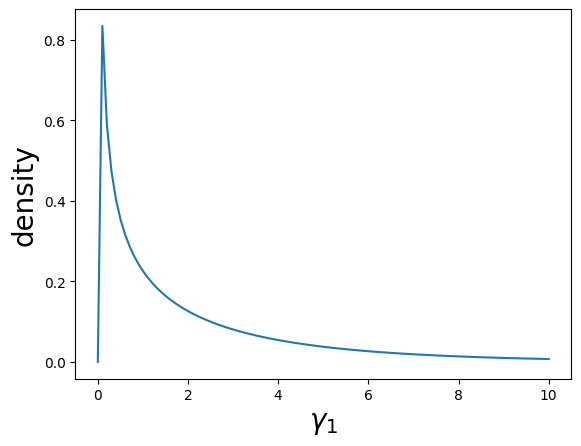

In [ ]:
# plot fitted distribution of gamma_0
lnspc = np.linspace(0, 10.0, 100)
ab,bb,cb,db = stats.beta.fit(gamma_1)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='$\\gamma_1$')
plt.xlabel('$\\gamma_1$', fontsize=20)
plt.ylabel('density', fontsize=20)

In [ ]:
if (def_model['calibrate']):
    
    gamma_0= np.array([0.0]*J, dtype='float32')
    i=0
    for el in CVA_0:
      gamma_0[i]=el['gamma_0']
      i+=1
    lnspc = np.linspace(np.min(gamma_0)-10, np.max(gamma_0)+10, 100)
    
    ab,bb,cb,db = stats.beta.fit(gamma_0)  
    pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
    plt.plot(lnspc, pdf_beta, label='$\\gamma_0$')
    plt.xlabel('$\\gamma_0$')
    plt.ylabel('density')

In [ ]:
i=0
CVA_0_tilde_UQ= np.array([0]*J, dtype='float32')
CVA_0_exact_UQ= np.array([0]*J, dtype='float32')
CVA_0_tilde_up_UQ= np.array([0]*J, dtype='float32')
CVA_0_tilde_down_UQ= np.array([0]*J, dtype='float32')


for el in CVA_0:
    CVA_0_tilde_UQ[i] = el['tilde']
    CVA_0_exact_UQ[i] = el['exact']
    CVA_0_tilde_up_UQ[i] = el['tilde_up']
    CVA_0_tilde_down_UQ[i] = el['tilde_down']
    i+=1

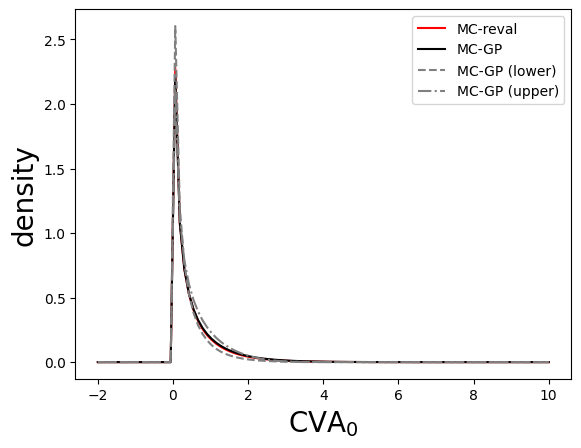

In [ ]:
# CVA_0 with UQ
# plot one year incremental CVA distribution
lnspc = np.linspace(-2.0, 10, 100)

ab,bb,cb,db = stats.beta.fit(CVA_0_exact_UQ)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-reval', color='r')

ab,bb,cb,db = stats.beta.fit(CVA_0_tilde_UQ)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-GP', color='k')

ab,bb,cb,db = stats.beta.fit(CVA_0_tilde_down_UQ)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-GP (lower)', color="grey", linestyle='--')

ab,bb,cb,db = stats.beta.fit(CVA_0_tilde_up_UQ)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-GP (upper)', color='grey', linestyle='-.')

plt.xlabel('CVA$_0$', fontsize=20)
plt.ylabel('density', fontsize=20)
plt.legend()
plt.show()

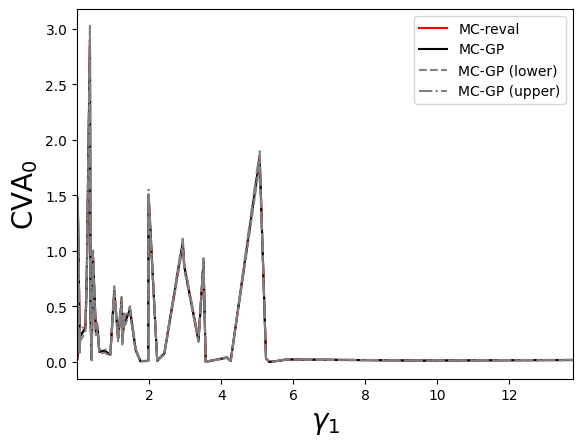

In [ ]:
# plot CVA_0 against gamma_1

idx=np.argsort(gamma_1)

ab,bb,cb,db = stats.beta.fit(np.array(CVA_0_exact_UQ[idx]))  
pdf_beta = stats.beta.pdf(gamma_1[idx], ab, bb,cb, db)  
plt.plot(gamma_1[idx], CVA_0_exact_UQ[idx], label='MC-reval', color='r')

ab,bb,cb,db = stats.beta.fit(np.array(CVA_0_tilde_UQ[idx]))  
pdf_beta = stats.beta.pdf(gamma_1[idx], ab, bb,cb, db)  
plt.plot(gamma_1[idx], CVA_0_tilde_UQ[idx], label='MC-GP', color='k')

ab,bb,cb,db = stats.beta.fit(np.array(CVA_0_tilde_down_UQ[idx]))  
pdf_beta = stats.beta.pdf(gamma_1[idx], ab, bb,cb, db)  
plt.plot(gamma_1[idx], CVA_0_tilde_down_UQ[idx], label='MC-GP (lower)', color="grey", linestyle='--')

ab,bb,cb,db = stats.beta.fit(np.array(CVA_0_tilde_up_UQ[idx]))  
pdf_beta = stats.beta.pdf(gamma_1[idx], ab, bb,cb, db)  
plt.plot(gamma_1[idx], CVA_0_tilde_up_UQ[idx], label='MC-GP (upper)', color="grey", linestyle='-.')


plt.xlabel('$\gamma_1$', fontsize=20)
plt.xlim([np.min(gamma_1),np.max(gamma_1)])
plt.ylabel('CVA$_0$', fontsize=20)
plt.legend()
plt.show()


In [ ]:
CVA_1_tilde_UQ = np.array([0.0]*J*M, dtype='float32').reshape(M, J)
CVA_1_tilde_up_UQ = np.array([0.0]*J*M, dtype='float32').reshape(M, J)
CVA_1_tilde_down_UQ = np.array([0.0]*J*M, dtype='float32').reshape(M, J)
CVA_1_exact_UQ = np.array([0.0]*J*M, dtype='float32').reshape(M, J)
i=0
for j in range(J):
    for m in range(M):
        el = CVA_1[i]
        CVA_1_tilde_UQ[m,j] = el['tilde']
        CVA_1_exact_UQ[m,j] = el['exact']
        CVA_1_tilde_up_UQ[m,j] = el['tilde_up']
        CVA_1_tilde_down_UQ[m,j] = el['tilde_down']
        i+=1

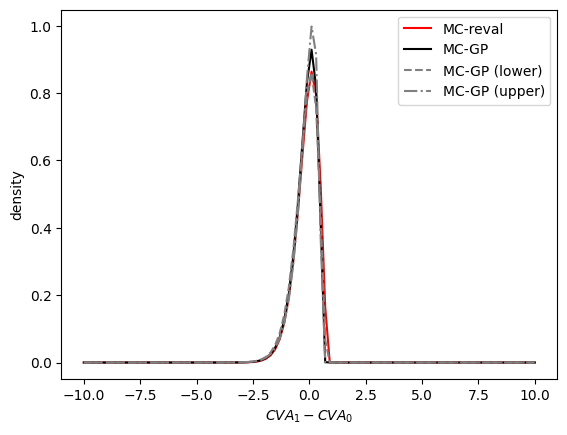

In [ ]:
lnspc = np.linspace(-10, 10.0, 100)

ab,bb,cb,db = stats.beta.fit(np.mean(CVA_1_exact_UQ,axis=0)-CVA_0_exact_UQ)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-reval', color='r')

ab,bb,cb,db = stats.beta.fit(np.mean(CVA_1_tilde_UQ, axis=0)-CVA_0_tilde_UQ)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-GP', color='k')

ab,bb,cb,db = stats.beta.fit(np.mean(CVA_1_tilde_up_UQ, axis=0)-CVA_0_tilde_up_UQ)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-GP (lower)', color="grey", linestyle='--')

ab,bb,cb,db = stats.beta.fit(np.mean(CVA_1_tilde_down_UQ, axis=0)-CVA_0_tilde_down_UQ)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-GP (upper)', color='grey', linestyle='-.')

plt.xlabel('$CVA_1 - CVA_0$')
plt.ylabel('density')
plt.legend()
plt.show()

/usr/local/lib/python3.9/dist-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.9/dist-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Text(0, 0.5, 'density')

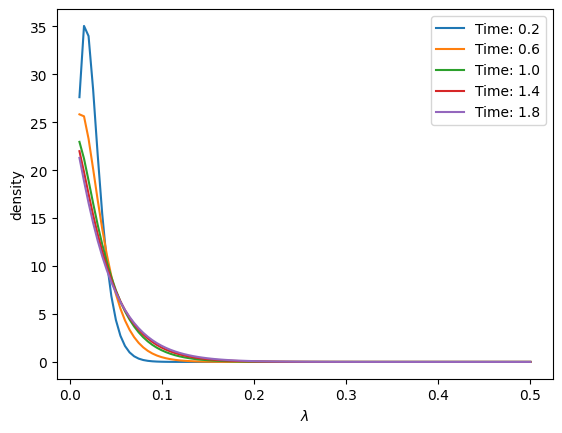

In [ ]:
dPD = np.array([0.0]*(nt-1)*sim_params['M']*J, dtype='float32').reshape((nt-1), sim_params['M'],J)             # default probabilities
    


k=0
for el in CVA_0:
    dPD[:,:,k] = el['dPD']
    k+=1

i=0    
for time in timegrid[1::2]:

    
# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
    
    lnspc = np.linspace(0.01, 0.5, 100)
    
    ab,bb,cb,db = stats.beta.fit(np.ravel(dPD[i,:,:]))
    pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
    plt.plot(lnspc, pdf_beta, label='Time: ' + str(time[0]))
    i+=1
    
 
plt.legend()
plt.xlabel('$\\lambda$')
plt.ylabel('density')

# CVA VaR

In [ ]:
CVA_VaR = []
CVA_VaR_tilde = []
CVA_VaR_tilde_down = []
CVA_VaR_tilde_up = []



for j in range(J):
  CVA_1_exact = []
  CVA_1_tilde = []  
  CVA_1_tilde_up = []  
  CVA_1_tilde_down = []  
  for i in range(M):  
    CVA_1_exact.append(CVA_1[j*M + i]['exact'][0])
    CVA_1_tilde.append(CVA_1[j*M + i]['tilde'][0])
    CVA_1_tilde_up.append(CVA_1[j*M + i]['tilde_up'][0])
    CVA_1_tilde_down.append(CVA_1[j*M + i]['tilde_down'][0])
  
  #print(np.max(np.array(CVA_1_exact)), CVA_0[j]['exact'])
  s_sorted=np.sort(np.array(CVA_1_exact)-CVA_0[j]['exact'])
  s_sorted_tilde=np.sort(np.array(CVA_1_tilde)-CVA_0[j]['tilde'])
  s_sorted_tilde_down=np.sort(np.array(CVA_1_tilde_down)-CVA_0[j]['tilde_up'])
  s_sorted_tilde_up=np.sort(np.array(CVA_1_tilde_up)-CVA_0[j]['tilde_down'])
  quantiles = np.array([0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,0.999])
  idx = np.array(len(s_sorted)*quantiles[9], dtype=int) 
  CVA_VaR.append(s_sorted[idx])
  CVA_VaR_tilde.append(s_sorted_tilde[idx])
  CVA_VaR_tilde_down.append(s_sorted_tilde_down[idx])
  CVA_VaR_tilde_up.append(s_sorted_tilde_up[idx])


/usr/local/lib/python3.9/dist-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.9/dist-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


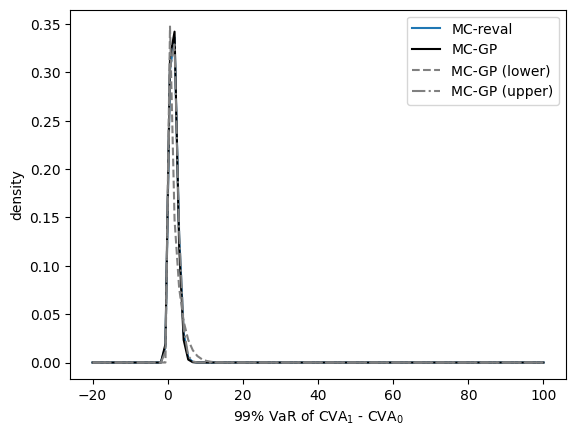

In [ ]:
lnspc = np.linspace(-20, 100.0, 100)

ab,bb,cb,db = stats.beta.fit(np.array(CVA_VaR))  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-reval')
ab,bb,cb,db = stats.beta.fit(np.array(CVA_VaR_tilde))  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-GP', color='k')

ab,bb,cb,db = stats.beta.fit(np.array(CVA_VaR_tilde_down))  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-GP (lower)', color="grey", linestyle='--')

ab,bb,cb,db = stats.beta.fit(np.array(CVA_VaR_tilde_up))  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-GP (upper)', color='grey', linestyle='-.')

plt.xlabel('99% VaR of CVA$_1$ - CVA$_0$')
plt.ylabel('density')
plt.legend()

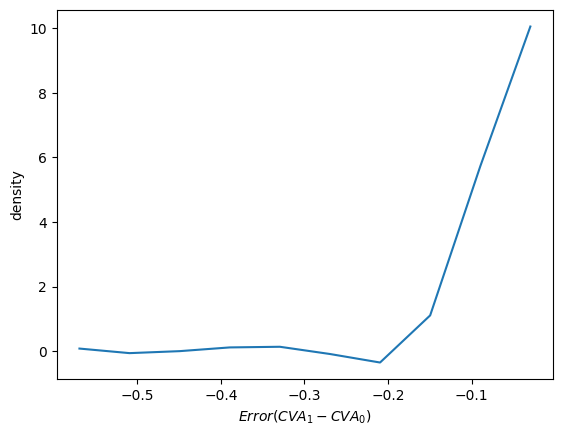

In [ ]:
s = (CVA_1_tilde_UQ-CVA_0_tilde_UQ) - (CVA_1_exact_UQ - CVA_0_exact_UQ)   # generate your data sample with N elements
p, x = np.histogram(s, bins=10, density=True) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = sp.interpolate.UnivariateSpline(x, p, s=1)
plt.plot(x, f(x))
plt.xlabel('$Error(CVA_1 - CVA_0)$')
plt.ylabel('density')
plt.show()  